**Passenger Survival Prediction on the Spaceship Titanic: An End-to-End ML Pipeline with CatBoost, LightGBM, and SHAP**

Install Required Libraries

In [1]:
# Install necessary libraries
!pip install catboost lightgbm shap -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


Import Libraries and Set Seed

In [2]:
# Import essential libraries for data handling, plotting, modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

# Ignore unnecessary warnings to keep output clean
warnings.filterwarnings("ignore")

# Scikit-learn modules for preprocessing, modeling, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# CatBoost and LightGBM models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Voting classifier for ensemble learning
from sklearn.ensemble import VotingClassifier

# Set a global seed for reproducibility
SEED = 42
np.random.seed(SEED)

Load Data

In [3]:
# Function to load the Spaceship Titanic dataset from GitHub links
def load_data():
    url_train = 'https://raw.githubusercontent.com/Assignment3StarshipTitanic/Assignment_3_StarshipTitanic/main/data/train.csv'
    url_test = 'https://raw.githubusercontent.com/Assignment3StarshipTitanic/Assignment_3_StarshipTitanic/main/data/test.csv'
    url_sample = 'https://raw.githubusercontent.com/Assignment3StarshipTitanic/Assignment_3_StarshipTitanic/main/data/sample_submission.csv'

    # Load datasets directly from GitHub
    train = pd.read_csv(url_train)
    test = pd.read_csv(url_test)
    submission = pd.read_csv(url_sample)

    # Add placeholders and merge
    test["Transported"] = np.nan
    train["source"] = "train"
    test["source"] = "test"
    full = pd.concat([train, test], sort=False)

    return train, test, submission, full

# Call the function to load data
train, test, submission, full = load_data()

Feature Engineering & Preprocessing

In [4]:
# Function to preprocess features and handle missing values
def preprocess_data(df):
    # Extract passenger group from ID and create group-related features
    df["Group"] = df["PassengerId"].apply(lambda x: x.split('_')[0])
    df["GroupSize"] = df.groupby("Group")["Group"].transform("count")
    df["IsAlone"] = (df["GroupSize"] == 1).astype(int)

    # Handle missing Cabin values and split it into Deck/CabinNum/Side
    df["Cabin"] = df["Cabin"].fillna("Z/0/Z")
    df[["Deck", "CabinNum", "Side"]] = df["Cabin"].str.split("/", expand=True)

    # Fill NA for common categorical features
    df["HomePlanet"] = df["HomePlanet"].fillna("Unknown")
    df["Destination"] = df["Destination"].fillna("Unknown")
    df["CryoSleep"] = df["CryoSleep"].fillna(False)
    df["VIP"] = df["VIP"].fillna(False)
    df["Age"] = df["Age"].fillna(df["Age"].median())    # Median imputation for age
    df["Name"] = df["Name"].fillna("Unknown")

    # Fill spending-related columns with 0
    spend_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    for col in spend_cols:
        df[col] = df[col].fillna(0)

    # Create new features
    df["TotalSpend"] = df[spend_cols].sum(axis=1)                 # Sum of all spendings
    df["LogSpend"] = np.log1p(df["TotalSpend"])                   # Log transformation
    df["AgeSpendInteraction"] = df["Age"] * df["TotalSpend"]      # Interaction term
    df["AgeGroup"] = pd.cut(df["Age"], bins=[0, 12, 18, 30, 50, 80],
                            labels=["Child", "Teen", "YoungAdult", "Adult", "Senior"])

    # Encode categorical features into numeric
    cat_cols = ["HomePlanet", "Destination", "Deck", "Side", "AgeGroup"]
    for col in cat_cols:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    # Convert boolean to integer
    df["CryoSleep"] = df["CryoSleep"].astype(int)
    df["VIP"] = df["VIP"].astype(int)

    # Drop unnecessary columns
    df.drop(columns=["PassengerId", "Name", "Cabin", "Group", "CabinNum", "source"], inplace=True, errors='ignore')
    return df

# Preprocess all data
full = preprocess_data(full)

Exploratory Data Analysis (EDA)

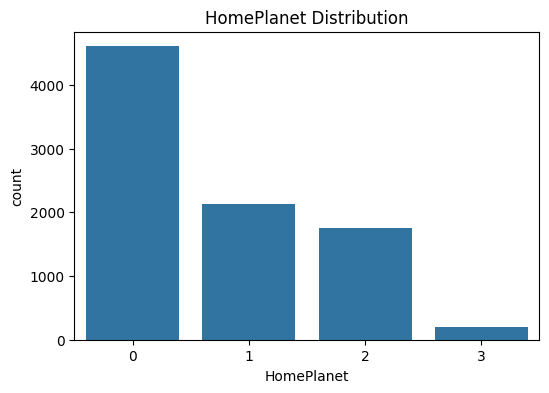

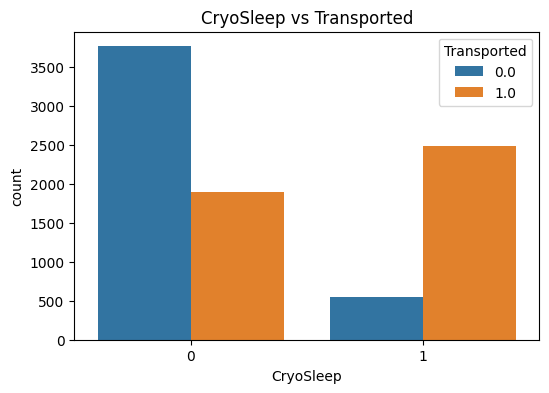

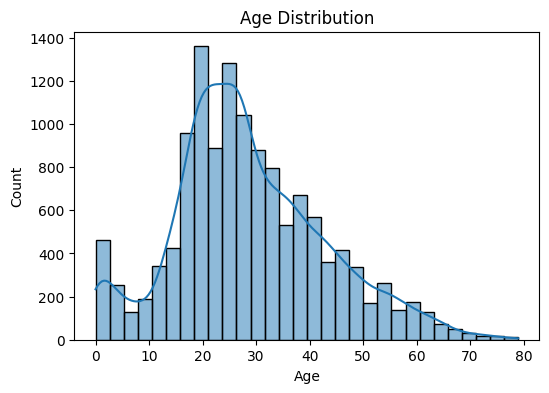

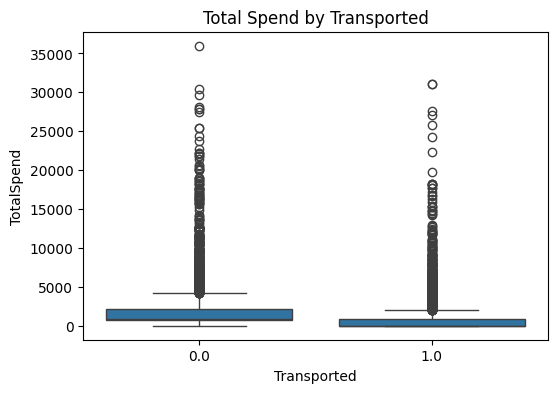

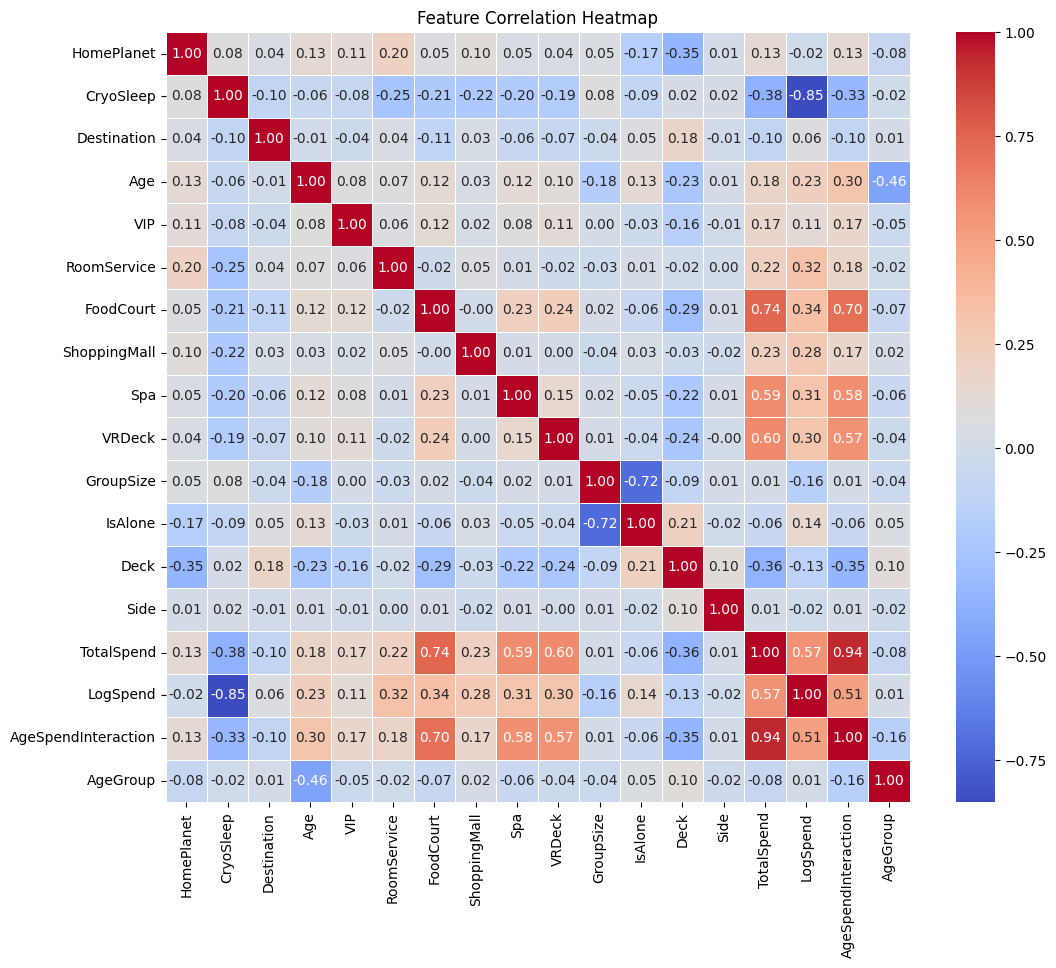

In [5]:
# Function to generate exploratory plots
def run_eda_plots(data):
    # Bar plot for HomePlanet
    plt.figure(figsize=(6, 4))
    sns.countplot(data=data[~data["Transported"].isna()], x="HomePlanet")
    plt.title("HomePlanet Distribution")
    plt.show()

    # CryoSleep vs Transported
    plt.figure(figsize=(6, 4))
    sns.countplot(x="CryoSleep", hue="Transported", data=data[~data["Transported"].isna()])
    plt.title("CryoSleep vs Transported")
    plt.show()

    # Age distribution
    plt.figure(figsize=(6, 4))
    sns.histplot(data["Age"], bins=30, kde=True)
    plt.title("Age Distribution")
    plt.show()

    # Boxplot for spend vs transported
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Transported", y="TotalSpend", data=data[~data["Transported"].isna()])
    plt.title("Total Spend by Transported")
    plt.show()

    # Heatmap for correlations
    plt.figure(figsize=(12, 10))
    corr = data.select_dtypes(include=["int64", "float64"]).corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("Feature Correlation Heatmap")
    plt.show()

# Run EDA
run_eda_plots(full)

Prepare Data for Modeling

In [6]:
# Split full dataset back into train and test
train_cleaned = full[~full["Transported"].isna()]
test_cleaned = full[full["Transported"].isna()].drop(columns=["Transported"])

# Separate features and target
X = train_cleaned.drop(columns=["Transported"])
y = train_cleaned["Transported"].astype(int)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test_cleaned)

Model Training

In [7]:
# Train CatBoost, LightGBM, and Voting Ensemble
def train_models(X_train, y_train):
    cat = CatBoostClassifier(verbose=0, random_seed=SEED)
    lgb = LGBMClassifier(random_state=SEED)
    ensemble = VotingClassifier(estimators=[('cat', cat), ('lgb', lgb)], voting='soft')

    # Fit models
    cat.fit(X_train, y_train)
    lgb.fit(X_train, y_train)
    ensemble.fit(X_train, y_train)

    return cat, lgb, ensemble

# Train all models
cat, lgb, voting = train_models(X_train_scaled, y_train)

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2168
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2168
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 18
[LightGBM] [Info] [binary:

Model Evaluation

In [8]:
# Function to evaluate and print results
def evaluate_model(model, X_val, y_val, name="Model"):
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_val, preds))
    print("Classification Report:\n", classification_report(y_val, preds))
    return acc

# Evaluate each model
acc_cat = evaluate_model(cat, X_val_scaled, y_val, "CatBoost")
acc_lgb = evaluate_model(lgb, X_val_scaled, y_val, "LightGBM")
acc_voting = evaluate_model(voting, X_val_scaled, y_val, "Voting Ensemble")


CatBoost Accuracy: 0.8085
Confusion Matrix:
 [[680 183]
 [150 726]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.80       863
           1       0.80      0.83      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739


LightGBM Accuracy: 0.8051
Confusion Matrix:
 [[679 184]
 [155 721]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80       863
           1       0.80      0.82      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.80      0.80      1739
weighted avg       0.81      0.81      0.80      1739


Voting Ensemble Accuracy: 0.8189
Confusion Matrix:
 [[688 175]
 [140 736]]
Classification Report:
               precision    recall  f1-score   support

     

Accuracy Comparison Plot

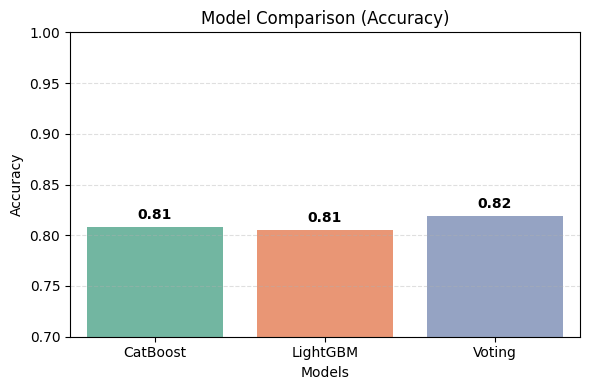

In [9]:
# Compare model accuracy in a bar chart
model_names = ['CatBoost', 'LightGBM', 'Voting']
accuracies = [acc_cat, acc_lgb, acc_voting]

plt.figure(figsize=(6, 4))
sns.barplot(x=model_names, y=accuracies, palette="Set2")

# Annotate bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.2f}", ha='center', va='bottom',
             fontsize=10, fontweight='bold', color='black')

plt.title("Model Comparison (Accuracy)")
plt.ylim(0.7, 1.0)
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

SHAP Explainability for LightGBM

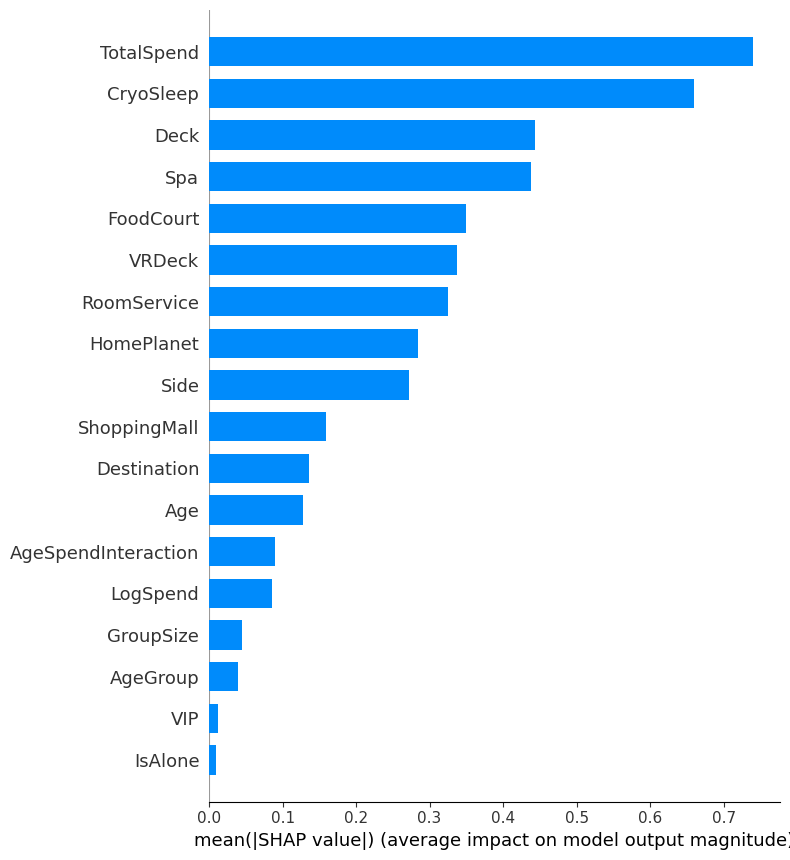

In [10]:
# Use SHAP to explain LightGBM predictions
explainer = shap.TreeExplainer(lgb)                       # Create explainer for LightGBM
shap_values = explainer.shap_values(X_val_scaled[:100])   # Calculate SHAP values

# Visualize SHAP feature importance
shap.summary_plot(shap_values, X_val.iloc[:100], plot_type="bar")

Final Prediction and Submission

In [11]:
# Make final predictions on test set
submission["Transported"] = voting.predict(test_scaled).astype(bool)

# Save to CSV
submission.to_csv("spaceship_submission_Final.csv", index=False)
print("Submission file saved as spaceship_submission_Final.csv")

Submission file saved as spaceship_submission_Final.csv
